In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [125]:
pd.options.mode.chained_assignment = None

In [126]:
four_wheels = lambda x, y: [f'{x}_rear_left_{y}', f'{x}_rear_right_{y}', f'{x}_front_left_{y}', f'{x}_front_right_{y}']

In [160]:
def clean_df(df, type):
    df['brakes_temperature'] = df[four_wheels(type, 'brakes_temperature')].mean(axis=1)
    df['tyres_surface_temperature'] = df[four_wheels(type, 'tyres_surface_temperature')].mean(axis=1)
    df['tyres_inner_temperature'] = df[four_wheels(type, 'tyres_inner_temperature')].mean(axis=1)
    df['tyres_pressure'] = df[four_wheels(type, 'tyres_pressure')].mean(axis=1)
    df['tyresDamage'] = df[four_wheels(type, 'tyresDamage')].mean(axis=1)
    
    df.drop(
        [*four_wheels(type, 'brakes_temperature'), *four_wheels(type, 'tyres_surface_temperature'), *four_wheels(type, 'tyres_inner_temperature'), *four_wheels(type, 'tyres_pressure'), *four_wheels(type, 'tyresDamage')], inplace=True, axis=1
    )
    return df

In [161]:
df = pd.read_parquet('./delta/lap_results/part-00000-f813030f-e90d-439c-aa61-c61a14fe0c92-c000.snappy.parquet')

In [162]:
df['lap_time'] = df['end_lap'] - df['start_lap']
df = df[df['lap_time'] < 120]

In [163]:
key_columns = ['driver', 'start_lap', 'end_lap', 'lap_time']

In [164]:
mean_df = clean_df(df[key_columns + df.filter(regex='^mean_').columns.tolist()], 'mean')
stddev_df = clean_df(df[key_columns + df.filter(regex='^stddev_').columns.tolist()], 'stddev')
min_df = clean_df(df[key_columns + df.filter(regex='^min_').columns.tolist()], 'min')
max_df = clean_df(df[key_columns + df.filter(regex='^max_').columns.tolist()], 'max')

In [180]:
tyre_consumption = max_df['tyresDamage'] - min_df['tyresDamage']
energy_deployed = max_df['max_ersDeployedThisLap']

Text(0, 0.5, 'Tyre Consumption (%)')

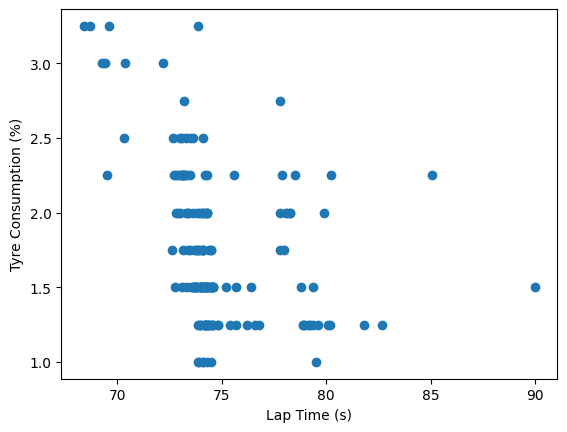

In [177]:
plt.scatter(min_df['lap_time'], tyre_consumption)
plt.xlabel('Lap Time (s)')
plt.ylabel('Tyre Consumption (%)')

Text(0, 0.5, 'Energy Deployed (%)')

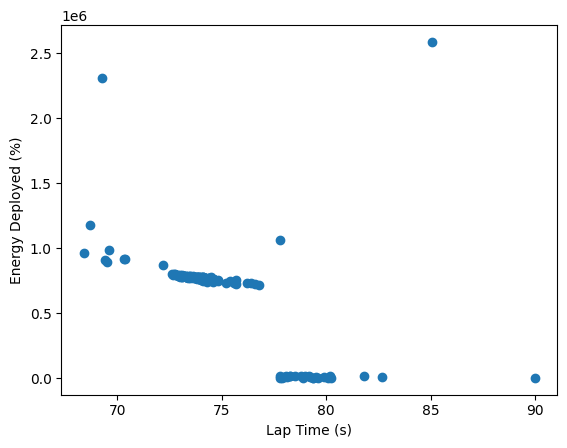

In [181]:
plt.scatter(min_df['lap_time'], energy_deployed)
plt.xlabel('Lap Time (s)')
plt.ylabel('Energy Deployed (%)')

In [194]:
from track.layouts.redbull_ring import waypoints

In [277]:
b = np.zeros((943,5))
b[:,:-1] = np.array(waypoints)

In [278]:
b[0:90, 4] = 1
b[90:120, 4] = 2
b[120:300, 4] = 3
b[300:340, 4] = 4
b[340:470, 4] = 5
b[470:540, 4] = 6
b[540:560, 4] = 7
b[560:650, 4] = 8
b[650:700, 4] = 9
b[700:750, 4] = 10
b[750:800, 4] = 11
b[800:850, 4] = 12
b[850:900, 4] = 13
b[900:, 4] = 1

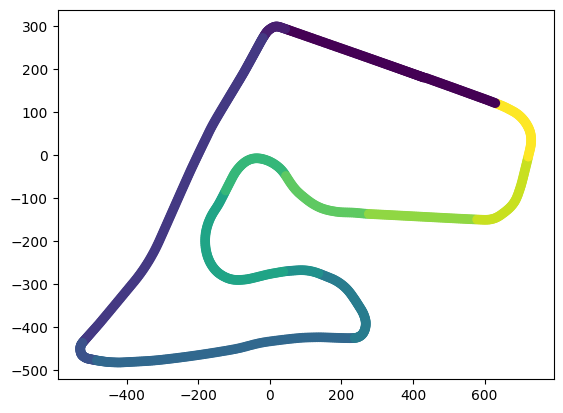

In [279]:
fig = plt.scatter(b[:, 0], b[:, 2], c=b[:, 4])
plt.show()

In [281]:
for i in b:
    print(
        f'[{i[0]}, {i[1]}, {i[2]}, {i[3]}, {i[4]}],'
    )

[430.23395, -42.521942, 181.16185, 0.0, 1.0],
[427.96384, -42.522537, 181.83403, 0.0005515969954964956, 1.0],
[425.6399, -42.522892, 182.5221, 0.0011162704810447784, 1.0],
[423.24774, -42.522663, 183.23021, 0.0016975096495131783, 1.0],
[420.7824, -42.52225, 183.95978, 0.0022965164880144433, 1.0],
[418.2059, -42.521206, 184.72234, 0.002922538291261634, 1.0],
[415.53287, -42.520336, 185.51352, 0.003572017654595141, 1.0],
[412.76807, -42.52004, 186.33176, 0.004243788013523262, 1.0],
[409.92453, -42.520454, 187.17314, 0.004934679251899111, 1.0],
[407.01004, -42.521626, 188.03555, 0.005642811577430399, 1.0],
[404.02774, -42.52356, 188.9177, 0.00636739825546031, 1.0],
[400.97614, -42.52574, 189.82022, 0.007108813757967509, 1.0],
[397.85605, -42.528454, 190.74286, 0.00786686065492507, 1.0],
[394.6706, -42.53134, 191.68459, 0.008640771533653531, 1.0],
[391.4213, -42.534187, 192.64508, 0.009430187186481686, 1.0],
[388.1075, -42.536427, 193.62462, 0.010235271898004567, 1.0],
[384.7399, -42.53726